# 1 Million Brain Cells
**Author:** [Severin Dicks](https://github.com/Intron7)

To run this notebook please make sure you have a working environment with all nessaray dependencies. Run the data_downloader notebook first to create the AnnData object we are working with. In this example workflow we'll be looking at a dataset of 1000000 brain cells from  [Nvidia](https://github.com/clara-parabricks/rapids-single-cell-examples/blob/master/notebooks/1M_brain_cpu_analysis.ipynb).

In [1]:
import scanpy as sc
import cupy as cp

import time
import rapids_singlecell as rsc

import warnings

warnings.filterwarnings("ignore")

In [2]:
import rmm
from rmm.allocators.cupy import rmm_cupy_allocator

rmm.reinitialize(
    managed_memory=False,  # Allows oversubscription
    pool_allocator=False,  # default is False
    devices=0,  # GPU device IDs to register. By default registers only GPU 0.
)
cp.cuda.set_allocator(rmm_cupy_allocator)

In [3]:
import gc

## Load and Prepare Data

We load the sparse count matrix from an `h5ad` file using Scanpy. The sparse count matrix will then be placed on the GPU. 

In [4]:
data_load_start = time.time()

In [5]:
%%time
adata = sc.read("h5/nvidia_1.3M.h5ad")
adata.var_names_make_unique()
adata = adata[:1_000_000, :].copy()

CPU times: user 57.1 s, sys: 10.2 s, total: 1min 7s
Wall time: 1min 8s


We now load the the AnnData object into VRAM.

In [6]:
%%time
rsc.get.anndata_to_GPU(adata)

CPU times: user 747 ms, sys: 3.4 s, total: 4.15 s
Wall time: 4.16 s


Verify the shape of the resulting sparse matrix:

In [7]:
adata.shape

(1000000, 27998)

In [8]:
data_load_time = time.time()
print("Total data load and format time: %s" % (data_load_time - data_load_start))

Total data load and format time: 72.75754356384277


## Preprocessing

In [9]:
preprocess_start = time.time()

### Quality Control

We perform a basic qulitiy control and plot the results

In [10]:
%%time
rsc.pp.flag_gene_family(adata, gene_family_name="MT", gene_family_prefix="mt-")

CPU times: user 4.99 ms, sys: 9 µs, total: 5 ms
Wall time: 5.02 ms


In [11]:
%%time
rsc.pp.calculate_qc_metrics(adata, qc_vars=["MT"])

CPU times: user 294 ms, sys: 10.8 ms, total: 305 ms
Wall time: 387 ms


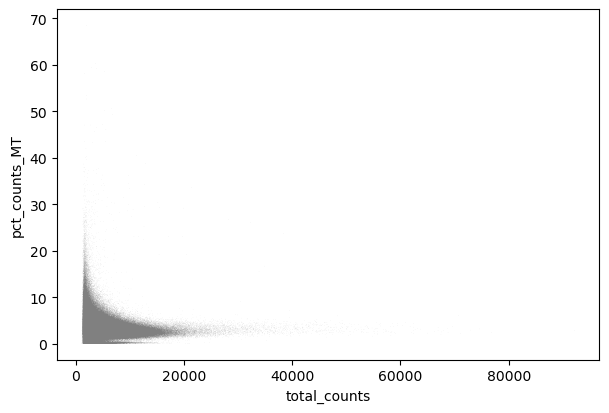

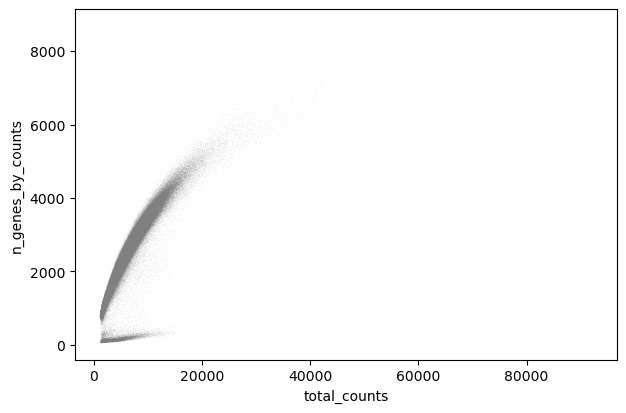

CPU times: user 3.64 s, sys: 365 ms, total: 4.01 s
Wall time: 3.69 s


In [12]:
%%time
sc.pl.scatter(adata, "total_counts", "pct_counts_MT")
sc.pl.scatter(adata, "total_counts", "n_genes_by_counts")

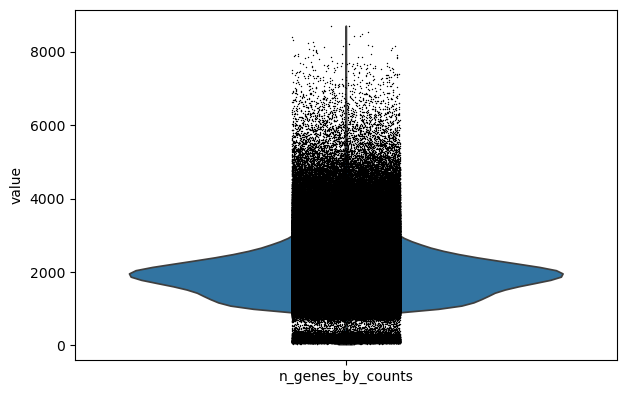

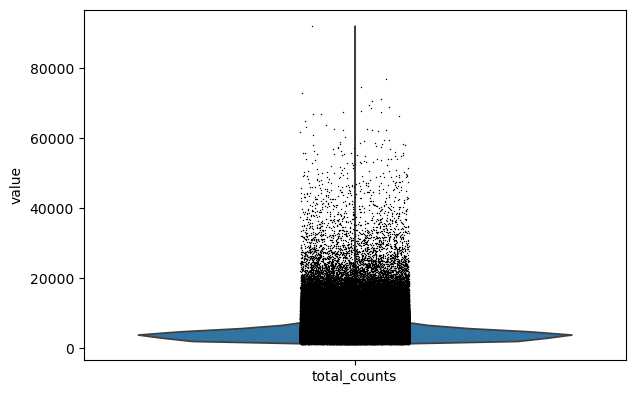

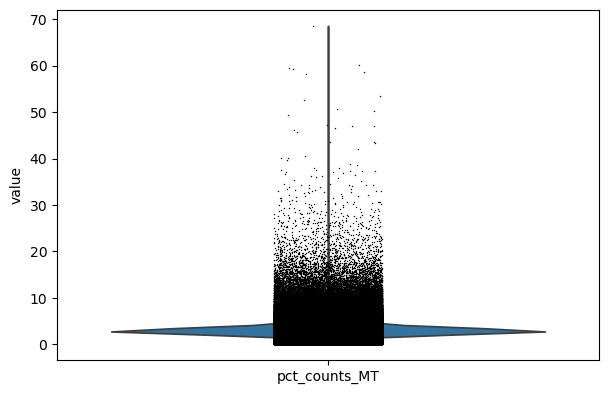

CPU times: user 18.7 s, sys: 36 s, total: 54.8 s
Wall time: 12.5 s


In [13]:
%%time
sc.pl.violin(adata, keys="n_genes_by_counts")
sc.pl.violin(adata, keys="total_counts")
sc.pl.violin(adata, keys="pct_counts_MT")

### Filter

We filter the count matrix to remove cells with an extreme number of genes expressed.
We also filter out cells with a mitchondrial countent of more than 20%.

In [14]:
%%time
adata = adata[
    (adata.obs["n_genes_by_counts"] < 5000)
    & (adata.obs["n_genes_by_counts"] > 500)
    & (adata.obs["pct_counts_MT"] < 20)
].copy()

CPU times: user 164 ms, sys: 26.2 ms, total: 190 ms
Wall time: 204 ms


Many python objects are not deallocated until garbage collection runs. When working with data that barely fits in memory (generally, >50%) you may need to manually trigger garbage collection to reclaim memory.

In [15]:
%%time
gc.collect()

CPU times: user 116 ms, sys: 28 ms, total: 144 ms
Wall time: 144 ms


9988

We also filter out genes that are expressed in less than 3 cells.

In [16]:
%%time
rsc.pp.filter_genes(adata, min_count=3)

filtered out 5401 genes based on n_cells_by_counts
CPU times: user 813 ms, sys: 70.2 ms, total: 883 ms
Wall time: 3.04 s


We store the raw expression counts in the `.layer["counts"]`

In [17]:
adata.layers["counts"] = adata.X.copy()

In [18]:
adata.shape

(982490, 22597)

### Normalize

We normalize the count matrix so that the total counts in each cell sum to 1e4.

In [19]:
%%time
rsc.pp.normalize_total(adata, target_sum=1e4)

CPU times: user 1.22 ms, sys: 0 ns, total: 1.22 ms
Wall time: 7.39 ms


Next, we log transform the count matrix.

In [20]:
%%time
rsc.pp.log1p(adata)

CPU times: user 70 ms, sys: 5.09 ms, total: 75.1 ms
Wall time: 173 ms


### Select Most Variable Genes

Now we search for highly variable genes. This function only supports the flavors `cell_ranger` `seurat` `seurat_v3` and `pearson_residuals`. As you can in scanpy you can filter based on cutoffs or select the top n cells. You can also use a `batch_key` to reduce batcheffects.

In this example we use `seurat_v3` for selecting highly variable genes based on the raw counts in `.layer["counts"]`. 

In [21]:
%%time
rsc.pp.highly_variable_genes(
    adata, n_top_genes=5000, flavor="seurat_v3", layer="counts"
)

CPU times: user 5.2 s, sys: 3.9 s, total: 9.1 s
Wall time: 5.92 s


In [22]:
%%time
rsc.get.anndata_to_CPU(adata, layer="counts")

CPU times: user 1.52 s, sys: 970 ms, total: 2.49 s
Wall time: 2.5 s


Now we safe this version of the AnnData as adata.raw.

In [23]:
%%time
adata.raw = adata

CPU times: user 1.22 s, sys: 943 ms, total: 2.17 s
Wall time: 2.17 s


Now we restrict our AnnData object to the highly variable genes.

In [24]:
%%time
adata = adata[:, adata.var["highly_variable"]]

CPU times: user 678 ms, sys: 1 s, total: 1.68 s
Wall time: 1.69 s


In [25]:
adata.shape

(982490, 5000)

Next we regress out effects of counts per cell and the mitochondrial content of the cells. As you can with scanpy you can use every numerical column in `.obs` for this.

In [26]:
%%time
rsc.pp.regress_out(adata, keys=["total_counts", "pct_counts_MT"])

CPU times: user 11.1 s, sys: 3.27 s, total: 14.3 s
Wall time: 17.4 s


### Scale

Finally, we scale the count matrix to obtain a z-score and apply a cutoff value of 10 standard deviations.

In [27]:
%%time
rsc.pp.scale(adata, max_value=10)

CPU times: user 476 ms, sys: 26.4 ms, total: 503 ms
Wall time: 1.51 s


### Principal component analysis

We use PCA to reduce the dimensionality of the matrix to its top 100 principal components. We use the PCA implementation from cuml to run this. With `use_highly_variable = False` we save VRAM since we already subset the matrix to only HVGs.

In [28]:
%%time
rsc.pp.pca(adata, n_comps=100, use_highly_variable=False)

CPU times: user 5.27 s, sys: 86.4 ms, total: 5.36 s
Wall time: 6.88 s


We can use scanpy `pca_variance_ratio` plot to inspect the contribution of single PCs to the total variance in the data.

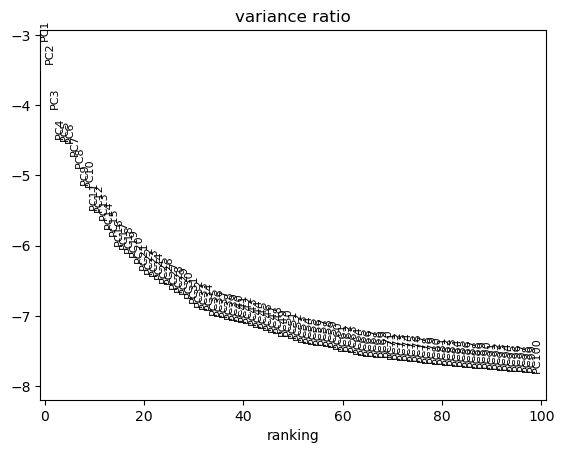

In [29]:
sc.pl.pca_variance_ratio(adata, log=True, n_pcs=100)

Now we move `.X` and `.layers` out of the GPU.

In [30]:
%%time
rsc.get.anndata_to_CPU(adata)

CPU times: user 1.1 s, sys: 1.23 s, total: 2.33 s
Wall time: 2.33 s


In [31]:
preprocess_time = time.time()
print("Total Preprocessing time: %s" % (preprocess_time - preprocess_start))

Total Preprocessing time: 61.350332260131836


Visualization## Clustering and Visualization

### Computing the neighborhood graph and UMAP

Next we compute the neighborhood graph using rsc.

Scanpy CPU implementation of nearest neighbor uses an approximation, while the GPU version calculates the exact graph. Both methods are valid, but you might see differences.

In [32]:
%%time
rsc.pp.neighbors(adata, n_neighbors=15, n_pcs=50)

CPU times: user 18.7 s, sys: 169 ms, total: 18.8 s
Wall time: 18.8 s


Next we calculate the UMAP embedding using rapdis.

In [33]:
%%time
rsc.tl.umap(adata, min_dist=0.3)

CPU times: user 2.42 s, sys: 122 ms, total: 2.54 s
Wall time: 2.54 s


### Clustering

Next, we use the Louvain and Leiden algorithm for graph-based clustering.

In [34]:
%%time
rsc.tl.louvain(adata, resolution=0.6)

CPU times: user 5.91 s, sys: 7.63 s, total: 13.5 s
Wall time: 17.8 s


In [35]:
%%time
rsc.tl.leiden(adata, resolution=1.0)

CPU times: user 1.93 s, sys: 4.78 s, total: 6.71 s
Wall time: 6.73 s


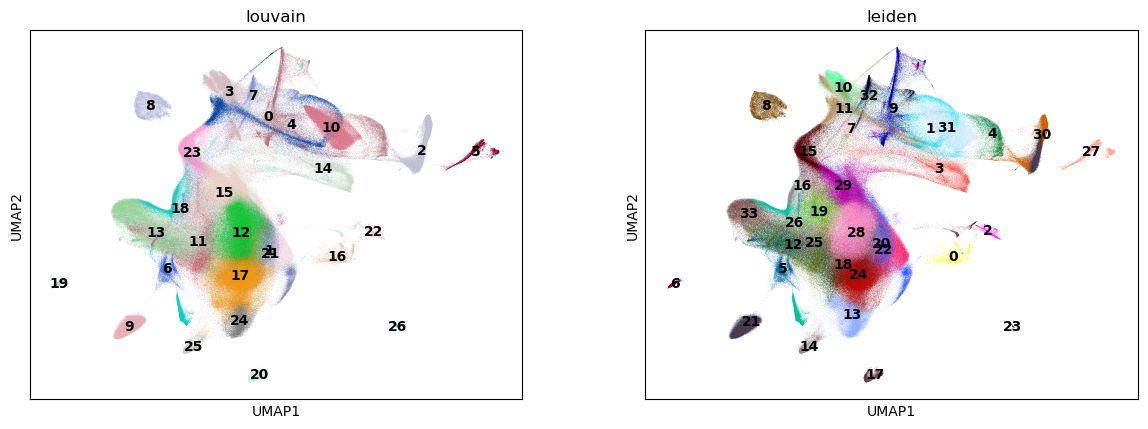

CPU times: user 4.72 s, sys: 182 ms, total: 4.9 s
Wall time: 4.73 s


In [36]:
%%time
sc.pl.umap(adata, color=["louvain", "leiden"], legend_loc="on data")

## TSNE

In [37]:
%%time
rsc.tl.tsne(adata, n_pcs=40)

[W] [17:15:19.868684] # of Nearest Neighbors should be at least 3 * perplexity. Your results might be a bit strange...
CPU times: user 22.4 s, sys: 9.33 s, total: 31.8 s
Wall time: 31.8 s


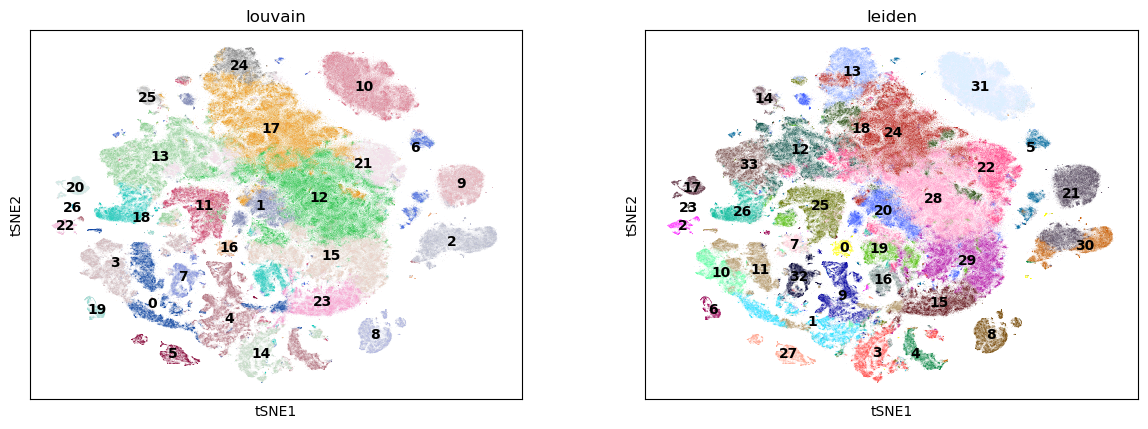

In [38]:
sc.pl.tsne(adata, color=["louvain", "leiden"], legend_loc="on data")

## Differential expression analysis

We now use logistic regression to compute a ranking for highly differential genes in each Louvaincluster.

In [39]:
%%time
rsc.tl.rank_genes_groups_logreg(adata, groupby="louvain", use_raw=False)

[W] [17:16:57.048840] L-BFGS stopped, because the line search failed to advance (step delta = 0.000000)
CPU times: user 41.3 s, sys: 19.4 s, total: 1min
Wall time: 1min


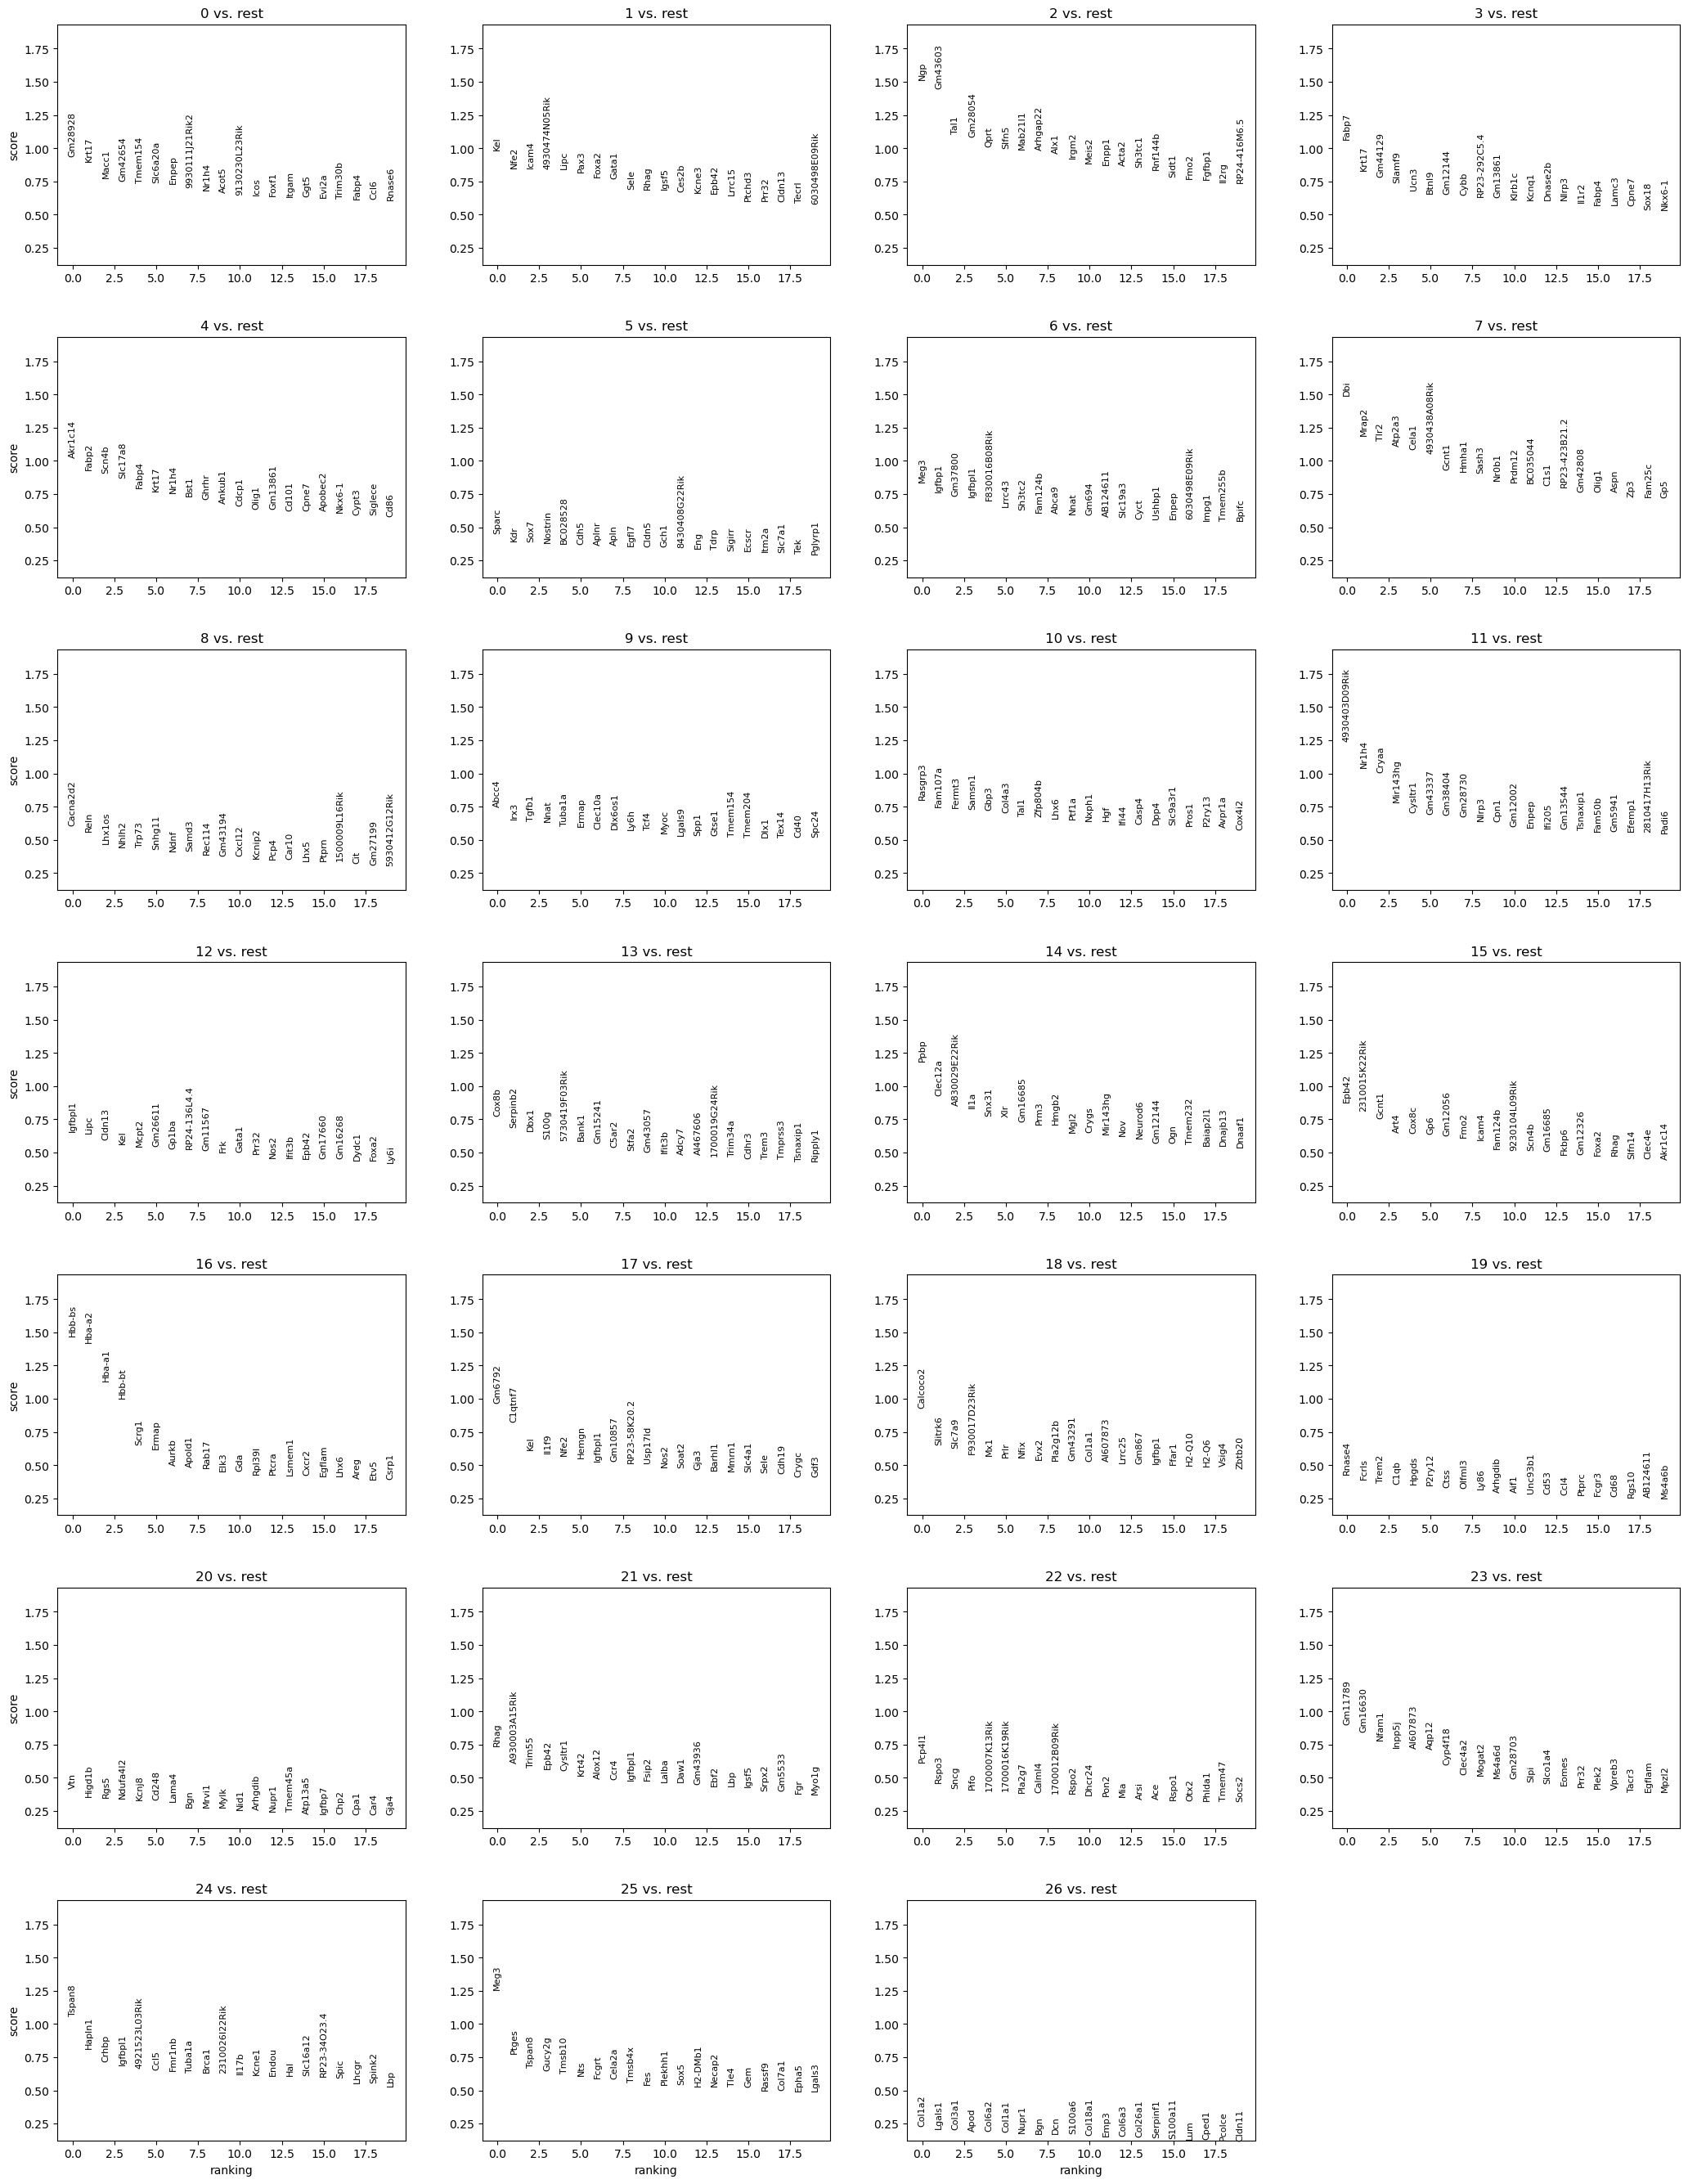

CPU times: user 2.77 s, sys: 297 ms, total: 3.06 s
Wall time: 2.89 s


In [40]:
%%time
sc.pl.rank_genes_groups(adata, n_genes=20)

## Diffusion Maps

In [41]:
%%time
rsc.tl.diffmap(adata)
adata.obsm["X_diffmap"] = adata.obsm["X_diffmap"][:, 1:]

CPU times: user 7.37 s, sys: 25.8 s, total: 33.2 s
Wall time: 2.95 s


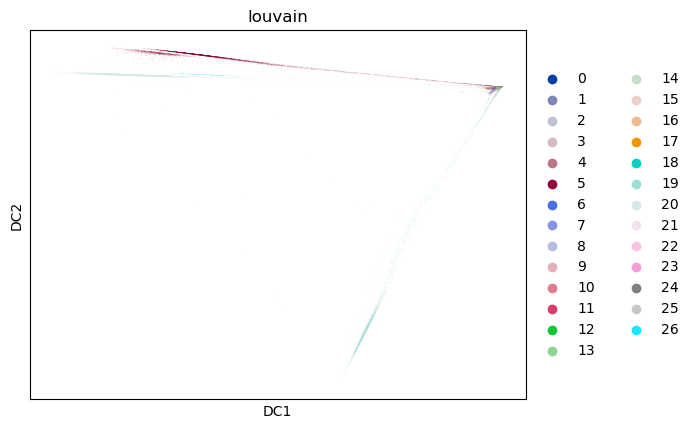

In [42]:
sc.pl.diffmap(adata, color="louvain")

After this you can use `X_diffmap` for `sc.pp.neighbors` and other functions. 

In [43]:
print("Total Processing time: %s" % (time.time() - preprocess_start))

Total Processing time: 217.8621642589569
